# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [1]:
import numpy as np

In [2]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [3]:
from sklearn.model_selection import train_test_split

# -- YOUR CODE HERE --
X1 = df.drop('salary_in_usd', axis = 1)
y1 = df['salary_in_usd']
X1_train_total, X1_test, y1_train_total, y1_test = train_test_split(X1, y1, test_size=0.1, random_state=42)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_train_total, y1_train_total, test_size=1/9, random_state=42)

Удалим признак `salary`, так как он напрямую связан с таргетом (`salary_in_usd`- это конвертированная в USD версия `salary`

In [4]:
X1_train, X1_val, X1_test = X1_train.drop('salary', axis=1), X1_val.drop('salary', axis=1), X1_test.drop('salary', axis=1)

Поскольку теперь валюта нам не нужна (все выражен в USD), можем также удалить признак `salary_currency`

In [5]:
X1_train, X1_val, X1_test = X1_train.drop('salary_currency', axis=1), X1_val.drop('salary_currency', axis=1), X1_test.drop('salary_currency', axis=1)

In [6]:
X1_train.head(4)

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
1174,2023,MI,FT,Data Engineer,US,0,US,M
3186,2022,SE,FT,Data Architect,US,100,US,M
2592,2022,MI,FT,Data Analyst,US,0,US,M
2159,2022,MI,FT,Data Analyst,US,0,US,M


## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import time

categorical_features = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size']

# -- YOUR CODE HERE --
numeric_features = [f for f in X1_train.columns if f not in categorical_features]

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X1_train_cat_enc = ohe.fit_transform(X1_train[categorical_features])
X1_train_numeric = X1_train[numeric_features].values
X1_train_enc = np.hstack([X1_train_numeric, X1_train_cat_enc])

X1_val_cat_enc = ohe.transform(X1_val[categorical_features])
X1_val_numeric = X1_val[numeric_features].values
X1_val_enc = np.hstack([X1_val_numeric, X1_val_cat_enc])

X1_test_cat_enc = ohe.transform(X1_test[categorical_features])
X1_test_numeric = X1_test[numeric_features].values
X1_test_enc = np.hstack([X1_test_numeric, X1_test_cat_enc])

lr = LinearRegression()
start_time = time.time()
lr.fit(X1_train_enc, y1_train)
end_time = time.time() - start_time

y1_pred = lr.predict(X1_test_enc)
mape = mean_absolute_percentage_error(y1_test, y1_pred)
rmse = np.sqrt(mean_squared_error(y1_test, y1_pred))
print('MAPE (%): ', 100*round(mape, 4))
print('RMSE: ', round(rmse, 3))
print('Время обучения: ', round(end_time, 3), "с.")

MAPE (%):  47.31
RMSE:  52301.352
Время обучения:  0.094 с.


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [10]:
from xgboost.sklearn import XGBRegressor

params = {}
best_mape = float('inf')

param_search = {
    'max_depth': range(2, 11),
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2],
    "min_child_weight": range(1, 6, 2)}

for d in param_search['max_depth']:
    for lr in param_search['learning_rate']:
        for n_est in param_search['n_estimators']:
            for g in param_search['gamma']:
                for c in param_search['min_child_weight']:
                    model = XGBRegressor(max_depth = d, learning_rate = lr, n_estimators=n_est, gamma = g, min_child_weight=c)
                    model.fit(X1_train_enc, y1_train)
                    y_pred = model.predict(X1_val_enc)
                    mape = mean_absolute_percentage_error(y1_val, y_pred)
                    if mape < best_mape:
                        best_mape = mape
                        params = {'max_depth': d, 'learning_rate': lr, 'n_estimators': n_est, 'gamma': g, "min_child_weight": c}
print('Лучшие параметры')
for f, v in params.items():
    print(f'{f}: {v}')

Лучшие параметры
max_depth: 10
learning_rate: 0.3
n_estimators: 200
gamma: 0
min_child_weight: 3


In [16]:
xgb = XGBRegressor(max_depth=10, learning_rate=0.3, n_estimators=200, gamma=0, min_child_weight = 3, random_state=42)

start_train = time.time()
xgb.fit(X1_train_enc, y1_train)
end_train = time.time() - start_train

start_pred = time.time()
y1_pred = xgb.predict(X1_test_enc)
end_pred = time.time() - start_pred

mape = mean_absolute_percentage_error(y1_test, y1_pred) * 100
rmse = np.sqrt(mean_squared_error(y1_test, y1_pred))

print('XGBRegressor')
print('MAPE (%): ', round(mape, 2))
print('RMSE: ', round(rmse, 2))
print('Время обучения (с): ', round(end_train, 2))
print('Время предсказания (с): ', round(end_pred, 2))

XGBRegressor
MAPE (%):  39.01
RMSE:  52146.22
Время обучения (с):  0.49
Время предсказания (с):  0.0


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [15]:
from catboost import CatBoostRegressor

params = {}

param_search = {
    'depth': range(1, 11),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [100, 200, 500],
    'l2_leaf_reg': [1, 3, 5]
}

best_mape = float('inf')
for d in param_search['depth']:
    for lr in param_search['learning_rate']:
        for i in param_search['iterations']:
            for l in param_search['l2_leaf_reg']:
                model = CatBoostRegressor(depth = d, learning_rate = lr, iterations= i, l2_leaf_reg=l, verbose=False)
                model.fit(X1_train_enc, y1_train)
                y_pred = model.predict(X1_val_enc)
                mape = mean_absolute_percentage_error(y1_val, y_pred)
                if mape < best_mape:
                    best_mape = mape
                    params = {'depth': d, 'learning_rate': lr, 'iterations': i, "l2_leaf_reg": l}
print('Лучшие параметры для CatBoostRegressor')
for f, v in params.items():
    print(f'{f}: {v}')

Лучшие параметры для CatBoostRegressor
depth: 6
learning_rate: 0.2
iterations: 200
l2_leaf_reg: 1


In [17]:
cat = CatBoostRegressor(depth = 6, learning_rate = 0.2, iterations= 200, l2_leaf_reg=1, verbose=False, random_state=42)

start_train = time.time()
cat.fit(X1_train_enc, y1_train)
end_train = time.time() - start_train

start_pred = time.time()
y1_pred = cat.predict(X1_test_enc)
end_pred = time.time() - start_pred

mape = mean_absolute_percentage_error(y1_test, y1_pred) * 100
rmse = np.sqrt(mean_squared_error(y1_test, y1_pred))

print('CatBoostRegressor')
print('MAPE (%): ', round(mape, 2))
print('RMSE: ', round(rmse, 2))
print('Время обучения (с): ', round(end_train, 2))
print('Время предсказания (с): ', round(end_pred, 2))

CatBoostRegressor
MAPE (%):  39.73
RMSE:  50005.08
Время обучения (с):  1.57
Время предсказания (с):  0.07


Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [19]:
from catboost import Pool

cat_features = [X1_train.columns.get_loc(col) for col in [
    'experience_level', 
    'employment_type', 
    'job_title',
    'employee_residence',
    'company_location',
    'company_size']]

train_pool = Pool(X1_train, y1_train, cat_features=cat_features)
val_pool = Pool(X1_val, y1_val, cat_features=cat_features)

param_search = {
    'depth': range(1, 11),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [100, 200, 500],
    'l2_leaf_reg': [1, 3, 5]
}

params = {}
best_mape = float('inf')
for d in param_search['depth']:
    for lr in param_search['learning_rate']:
        for i in param_search['iterations']:
            for l in param_search['l2_leaf_reg']:
                model = CatBoostRegressor(depth = d, learning_rate = lr, iterations= i, l2_leaf_reg=l, verbose=False, random_state=42)
                model.fit(train_pool)
                y_pred = model.predict(val_pool)
                mape = mean_absolute_percentage_error(y1_val, y_pred)
                if mape < best_mape:
                    best_mape = mape
                    params = {'depth': d, 'learning_rate': lr, 'iterations': i, "l2_leaf_reg": l}
print('Лучшие параметры для CatBoostRegressor c Pool')
for f, v in params.items():
    print(f'{f}: {v}')        

Лучшие параметры для CatBoostRegressor c Pool
depth: 4
learning_rate: 0.2
iterations: 100
l2_leaf_reg: 5


In [21]:
cat = CatBoostRegressor(depth = 4, learning_rate = 0.2, iterations= 100, l2_leaf_reg=2, verbose=False, random_state=42)

test_pool = Pool(X1_test, y1_test, cat_features=cat_features)

start_train = time.time()
cat.fit(train_pool)
end_train = time.time() - start_train

start_pred = time.time()
y1_pred = cat.predict(test_pool)
end_pred = time.time() - start_pred

mape = mean_absolute_percentage_error(y1_test, y1_pred) * 100
rmse = np.sqrt(mean_squared_error(y1_test, y1_pred))

print('CatBoostRegressor c Pool')
print('MAPE (%): ', round(mape, 2))
print('RMSE: ', round(rmse, 2))
print('Время обучения (с): ', round(end_train, 2))
print('Время предсказания (с): ', round(end_pred, 2))

CatBoostRegressor c Pool
MAPE (%):  43.31
RMSE:  51325.76
Время обучения (с):  1.4
Время предсказания (с):  0.0


**Ответ:** качество ухудшилось, время обучения и предсказания уменьшилось

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [32]:
from lightgbm import LGBMRegressor

params = {}
best_mape = float('inf')

param_search = {
    'max_depth': range(2, 11),
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'num_leaves': [15, 30, 60, 120, 1000]}

for d in param_search['max_depth']:
    for lr in param_search['learning_rate']:
        for n_est in param_search['n_estimators']:
            for l in param_search['num_leaves']:
                model = LGBMRegressor(max_depth = d, learning_rate = lr, n_estimators=n_est, num_leaves=l, verbosity=-1, random_state=42)
                model.fit(X1_train_enc, y1_train)
                y_pred = model.predict(X1_val_enc)
                mape = mean_absolute_percentage_error(y1_val, y_pred)
                if mape < best_mape:
                    best_mape = mape
                    params = {'max_depth': d, 'learning_rate': lr, 'n_estimators': n_est, 'num_leaves': l}
print('Лучшие параметры для LGBMRegressor')
for f, v in params.items():
    print(f'{f}: {v}')

C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\skl

C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\skl

C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\skl

C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\skl

C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\skl

C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\skl

C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\skl

C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\skl

C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\skl

C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\skl

C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\skl

C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\skl

C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\skl

Лучшие параметры для LGBMRegressor
max_depth: 6
learning_rate: 0.2
n_estimators: 300
num_leaves: 30


C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [31]:
lgbmr = LGBMRegressor(max_depth = 6, learning_rate = 0.2, n_estimators=300, num_leaves=30, verbosity=-1, random_state=42)

start_train = time.time()
lgbmr.fit(X1_train_enc, y1_train)
end_train = time.time() - start_train

start_pred = time.time()
y1_pred = lgbmr.predict(X1_test_enc)
end_pred = time.time() - start_pred

mape = mean_absolute_percentage_error(y1_test, y1_pred) * 100
rmse = np.sqrt(mean_squared_error(y1_test, y1_pred))

print('LGBMRegressor')
print('MAPE (%): ', round(mape, 2))
print('RMSE: ', round(rmse, 2))
print('Время обучения (с): ', round(end_train, 2))
print('Время предсказания (с): ', round(end_pred, 2))

LGBMRegressor
MAPE (%):  42.26
RMSE:  51680.3
Время обучения (с):  0.11
Время предсказания (с):  0.01


C:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

In [37]:
from tabulate import tabulate
data = [
    ["XGBoost", 
     "{'max_depth':10, 'learning_rate':0.3, 'n_estimators':200, 'gamma':0, 'min_child_weight':3}", 
     39.01, 52146.22, 0.49, 0.0],
    ["CatBoost", 
     "{'depth':6, 'learning_rate':0.2, 'iterations':200, 'l2_leaf_reg':1}", 
     39.73, 50005.08, 1.57, 0.07],
    ["LightGBM", 
     "{'max_depth':6, 'learning_rate':0.2, 'n_estimators':300, 'num_leaves':30}", 
     42.26, 51680.3, 0.11, 0.01]
]

result = pd.DataFrame(data, columns=["Модель", "Лучшие параметры", "MAPE (%)", "RMSE", 
                                "Время обучения (с)", "Время предсказания (с)"])

result

,Модель,Лучшие параметры,MAPE (%),RMSE,Время обучения (с),Время предсказания (с)
0,XGBoost,"{'max_depth':10, 'learning_rate':0.3, 'n_estim...",39.01,52146.22,0.49,0.00
1,CatBoost,"{'depth':6, 'learning_rate':0.2, 'iterations':...",39.73,50005.08,1.57,0.07
2,LightGBM,"{'max_depth':6, 'learning_rate':0.2, 'n_estima...",42.26,51680.30,0.11,0.01


**Ответ:**
* Лучшей по точности модель оказалась `CatBoost` c наименьшим RMSE, хотя если оценивать по MAPE, то это будет `XGBoost`
* Худшей можно назвать `LightGBM`c наимбольшим МАРЕ
* Самой быстрой моделью определнно стала `LightGBM`, так как она в 14 раз быстрее `CatBoost` и в 4,5 раза быстрее `XGBoost`, это было заметно еще при подборе гиперпараметров
* Скорость предсказания у `LightGBM` (0.01) и `XGBoost` (0.00) почти мгновенная, и только у `CatBoost` она равна 0.07 с.
* Гиперпараметры: параметры `depth` и `iterations` в `Catboost` аналогичны `max_depth` и `n_estimators` в XGBoost. `XGBoost` использует `gamma` и  `min_child_weight`

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [38]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [65]:
# -- YOUR CODE HERE --
ratings_new = ratings.T
ratings_new

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
user,0.000000,1.000000,2.000000,3.0,4.000000,5.000000,6.0,7.0,8.000000,9.000000,...,4990.000000,4991.0,4992.000000,4993.000000,4994.000000,4995.000000,4996.0,4997.000000,4998.0,4999.000000
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
群星,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agalloch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
meshuggah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием `user`.

In [66]:
# -- YOUR CODE HERE --
ratings_new = ratings_new.drop(index=['user'])
ratings_new.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
modest mouse,NaN,NaN,NaN,NaN,0.015935,NaN,NaN,NaN,NaN,0.030437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [67]:
# -- YOUR CODE HERE --
ratings_new = ratings_new.fillna(0)
ratings_new.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
de la soul,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014324,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [68]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=5, random_state=42)
k_means = k_means.fit(ratings_new)
clusters = k_means.predict(ratings_new)

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [70]:
# -- YOUR CODE HERE --
ratings_new['cluster_k_means'] = clusters
ratings_new['cluster_k_means'].value_counts().sort_index()

cluster_k_means
0    115
1      1
2      1
3    882
4      1
Name: count, dtype: int64

**Ответ:** Кластеры сильно не сбалансированы, поэтому кластеризация получилась скорее бесполезной. 88.2% исполнителей попали в один класс. Такой результат мог получится в результате того, что у польшинства пар (пользователь, исполнитель) имеют значение 0. Также возможно стоило указать меньшее количество кластеров, например 2

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [78]:
# -- YOUR CODE HERE --
ratings_new[ratings_new['cluster_k_means'].isin([1, 2, 4])].index

Index(['the beatles', 'niИ', '日dir en grey'], dtype='object')

Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [92]:
# -- YOUR CODE HERE --

whole = (ratings_new.drop('cluster_k_means', axis=1) > 0)
user_share = whole.sum(axis=1) / whole.shape[1]
mean_share = ratings_new.drop('cluster_k_means', axis=1)[ratings_new.drop('cluster_k_means', axis=1)>0].mean(axis=1)

shares = pd.DataFrame({'user_share': user_share, 'mean_share': mean_share})
shares.sort_values('user_share', ascending=False)

,user_share,mean_share
the beatles,0.3342,0.054964
radiohead,0.2778,0.042661
deathcab for cutie,0.1862,0.035141
coldplay,0.1682,0.035852
modest mouse,0.1628,0.036095
...,...,...
curtis mayfield,0.0094,0.036225
townes van zandt,0.0094,0.051466
municipal waste,0.0094,0.058503
refused,0.0094,0.049813


**Ответ:** заметим, что у `the beatles` наибольшая доля слушателей, их слушают многие и часто, поэтому это они являются выбросом и KMeans вынужден их выделить в отдельный кластер

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [161]:
from sklearn.preprocessing import normalize
r = ratings_new.drop('cluster_k_means', axis=1)
ratings_norm = normalize(r)
ratings_norm = pd.DataFrame(ratings_norm, index=r.index, columns=r.columns)
ratings_norm.head()
# -- YOUR CODE HERE --

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,0.000000,0.000000,0.000000,0.0,0.012054,0.000000,0.0,0.0,0.025864,0.004880,...,0.000000,0.0,0.033554,0.010569,0.002199,0.004952,0.0,0.021302,0.0,0.000000
radiohead,0.009348,0.084688,0.000000,0.0,0.039505,0.002894,0.0,0.0,0.000000,0.008771,...,0.008120,0.0,0.000000,0.000000,0.005122,0.000000,0.0,0.000000,0.0,0.000000
deathcab for cutie,0.000000,0.017278,0.020144,0.0,0.024333,0.000000,0.0,0.0,0.000000,0.009391,...,0.085361,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.019622
coldplay,0.000000,0.000000,0.000000,0.0,0.011129,0.000000,0.0,0.0,0.000000,0.000000,...,0.144628,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
modest mouse,0.000000,0.000000,0.000000,0.0,0.010260,0.000000,0.0,0.0,0.000000,0.019597,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [162]:
# -- YOUR CODE HERE --
k_means4 = KMeans(n_clusters=5, random_state=42)
k_means4 = k_means4.fit(ratings_norm)
clusters4 = k_means4.predict(ratings_norm)
ratings_norm['cluster4'] = clusters4
ratings_norm['cluster4'].value_counts().sort_index()

cluster4
0     79
1    162
2    133
3    140
4    486
Name: count, dtype: int64

**Ответ**: да, нормализация помогла, так как теперь классы более менее сбалансированны и нет слишком маленьких классов. Поэтому теперь кластеризация может быть полезной для выявление типов исполнителей

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [163]:
from scipy.spatial.distance import cosine


centroids = k_means4.cluster_centers_

# -- YOUR CODE HERE --
top10 = {}

for i in range(5):
    artist_i = ratings_norm[ratings_norm['cluster4'] == i].drop('cluster4', axis=1)
    dist = artist_i.apply(lambda x: cosine(x, centroids[i]), axis=1)
    top10[i] = dist.sort_values().head(10).index.tolist()

pd.DataFrame(top10)

,0,1,2,3,4
0,nas,fall out boy,brand new,the beatles,radiohead
1,jay-z,the all-americian rejects,blink-182,the rolling stones,the arcade fire
2,kanye west,paramore,alkaline trio,dylan. bob,the shins
3,lupe the gorilla,kelly clarkson,against me!,who,sufjan stevens
4,a tribe called quest,john mayer,underoath,led zeppelin.,belle and sebastian
5,the roots featuring d'angelo,the fray,descendents,miles davis.,broken social scene
6,gangstarr,maroon5,new found glory,simon and garfunkel,the pixies
7,little brother,dashboard confesssional,less than jake,"young, neil",animal collective
8,lil' wayne,somethings corporate,thrice,pink fluid,modest mouse
9,murs and 9th wonder,coldplay,chiodos,velvet underground,spoon


**Ответ:** данные исполнители являются "идеальными" для своего класса, в полной мере соответсвующие его описанию. Скорее всего кластеры определяют какой-либо жанр, например, исполнители нулевого кластера являются представителями хип-хопа/рэпа. Дальше я особо в музыке на разбираюсь

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

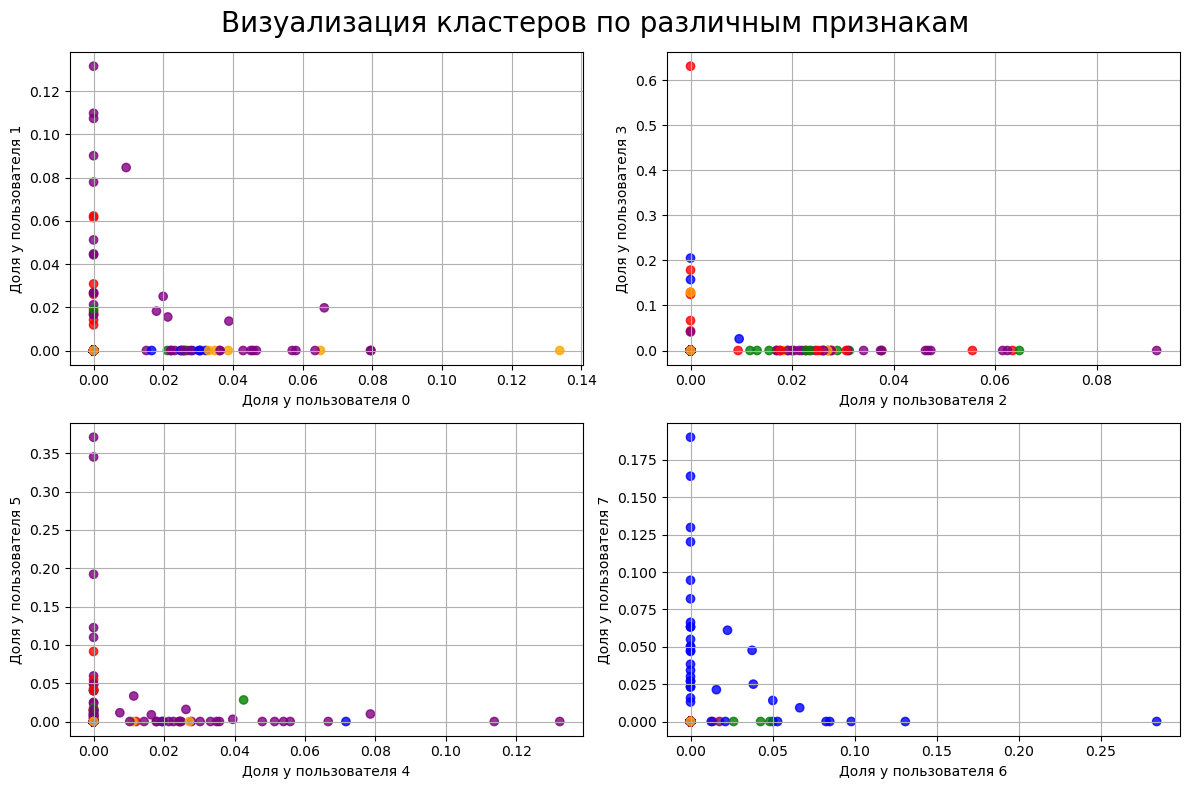

In [164]:
import matplotlib.pyplot as plt

cluster_colors = {
    0: 'blue',
    1: 'orange', 
    2: 'green',
    3: 'red',
    4: 'purple'
}
colors = ratings_norm['cluster4'].map(cluster_colors)

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
plt.suptitle('Визуализация кластеров по различным признакам', fontsize = 20)
ax[0, 0].scatter(ratings_norm.iloc[:, 0], ratings_norm.iloc[:, 1], c=colors, alpha=0.8)
ax[0, 0].set_xlabel(f"Доля у пользователя {ratings_norm.columns[0]}")
ax[0, 0].set_ylabel(f"Доля у пользователя {ratings_norm.columns[1]}")
ax[0, 0].grid(True)

ax[0, 1].scatter(ratings_norm.iloc[:, 2], ratings_norm.iloc[:, 3], c=colors, alpha=0.8)
ax[0, 1].set_xlabel(f"Доля у пользователя {ratings_norm.columns[2]}")
ax[0, 1].set_ylabel(f"Доля у пользователя {ratings_norm.columns[3]}")
ax[0, 1].grid(True)

ax[1, 0].scatter(ratings_norm.iloc[:, 4], ratings_norm.iloc[:, 5], c=colors, alpha=0.8)
ax[1, 0].set_xlabel(f"Доля у пользователя {ratings_norm.columns[4]}")
ax[1, 0].set_ylabel(f"Доля у пользователя {ratings_norm.columns[5]}")
ax[1, 0].grid(True)

ax[1, 1].scatter(ratings_norm.iloc[:, 6], ratings_norm.iloc[:, 7], c=colors, alpha=0.8)
ax[1, 1].set_xlabel(f"Доля у пользователя {ratings_norm.columns[6]}")
ax[1, 1].set_ylabel(f"Доля у пользователя {ratings_norm.columns[7]}")
ax[1, 1].grid(True)

plt.tight_layout()
plt.show()

**Ответ:** Визуализация получилась ненагядной, так как в качестве признаков мы брали конкретных пользователей, только на основании которых тяжело разделить. К тому же разделение на классы плохо различимо

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

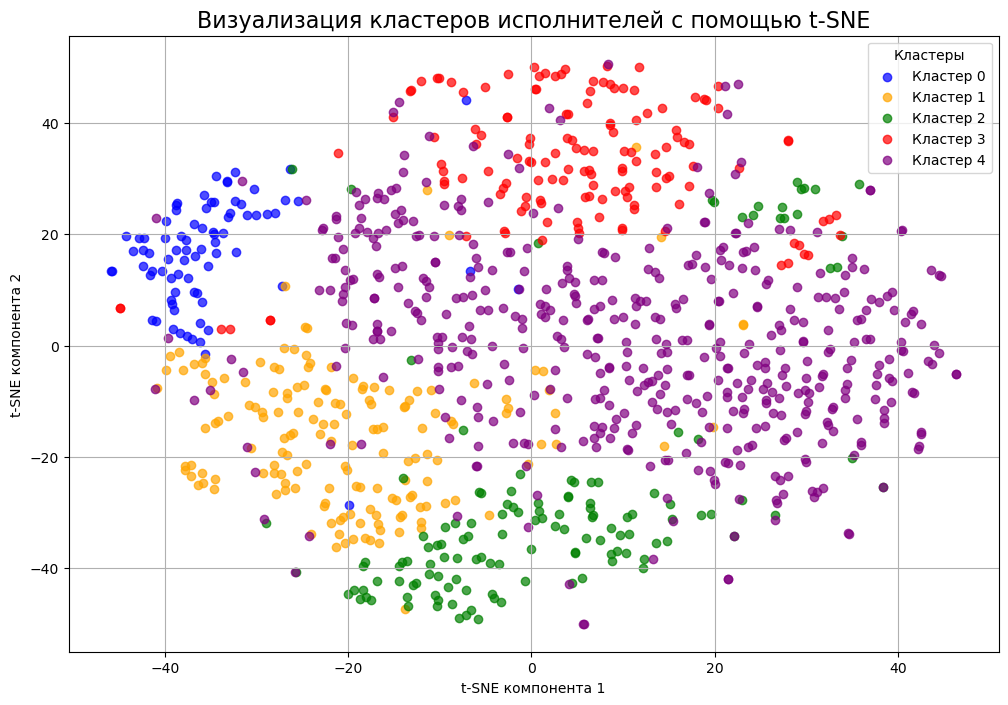

In [165]:
from sklearn.manifold import TSNE

X = ratings_norm.drop('cluster4', axis=1)
y = ratings_norm['cluster4']
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12, 8))

cluster_colors = {
    0: 'blue',
    1: 'orange', 
    2: 'green',
    3: 'red',
    4: 'purple'
}
for cluster in cluster_colors:
    mask = y == cluster
    plt.scatter(
        X_tsne[mask, 0], 
        X_tsne[mask, 1],
        c=cluster_colors[cluster],
        label=f'Кластер {cluster}',
        alpha=0.7
    )
    
plt.title('Визуализация кластеров исполнителей с помощью t-SNE', fontsize=16)
plt.xlabel('t-SNE компонента 1')
plt.ylabel('t-SNE компонента 2')
plt.legend(title='Кластеры')
plt.grid(True)
# -- YOUR CODE HERE --

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [166]:
from sklearn.metrics import silhouette_score

# -- YOUR CODE HERE --
X = ratings_norm.drop('cluster4', axis=1)
best_k, best_score = None, -1
for k in range(2, 101):
    k_means = KMeans(n_clusters = k, random_state=42)
    k_means = k_means.fit(X)
    clusters = k_means.predict(X)
    score = silhouette_score(X=X, labels=clusters)
    
    if score > best_score:
        best_score = score
        best_k = k
print(f'Best score: {round(best_score, 2)}, k = {best_k}')

Best score: 0.01, k = 98


Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [167]:
X = ratings_norm.drop('cluster4', axis=1)
k_means7 = KMeans(n_clusters = 98, random_state=42)
k_means7 = k_means7.fit(X)
clusters7 = k_means.predict(X)
ratings7 = X.copy()
ratings7['cluster7'] = clusters7

In [171]:
# -- YOUR CODE HERE --
centroids = k_means7.cluster_centers_

# -- YOUR CODE HERE --
top10 = {}

for i in range(98):
    artist_i = ratings7[ratings7['cluster7'] == i].drop('cluster7', axis=1)
    dist = artist_i.apply(lambda x: cosine(x, centroids[i]), axis=1)
    top10[i] = dist.sort_values().head(10).index.tolist()

for k, v in top10.items(): 
    print(f'Кластер: {k}:')
    for n in v:
        print(n)

Кластер: 0:
dr. dre
the faint
violent femmes
margot and the nuclear so and sos
owen
the bloodhound gang
Кластер: 1:
john mayer
matt nathanson
gavin degraw
jason mraz
ray lamontagne
joshua radin
sara bareilles
augustana
maroon5
o.a.r.
Кластер: 2:
white stripes
beck
the raconteurs
spoon
the strokes
the flaming lips
cake
black rebel motorcycle club
gorillaz
the black keys
Кластер: 3:
fugazi
jawbreaker
sleater-kinney
les savy fav
capn jazz
bad brains
propagandhi
gogol bordello
Кластер: 4:
ryan adams
band of horses
ryan adams and the cardinals
rogue wave
my morning jacket
matt pond pa
cloud cult
the american analog set
nada surf
tv on the radio
Кластер: 5:
dj shadow
rjd2
amon tobin
jedi mind tricks
el-p
sublime
moby*
gnarls barkley
soul coughing
silversun pickups
Кластер: 6:
system of a down
koЯn
mudvayne
limpt bizkit
disturbed
slipknot
papa roach
godsmack
marilyn manson
fort minor
Кластер: 7:
somethings corporate
the rocket summer
jack’s mannequin
cartel
the format
travis
Кластер: 8:
chiod

**Ответ:** При 5 кластерах наблюдались крупные жанровые группы, тогда же как при 98 появилась тонкое разделение на виды жанров, возможно, подниши, эпохи

Например, можно выделить Кластер 89, где представлены исполнители 90-х годов преимущественного, при 5 кластерах они были в разных

Сделайте t-SNE визуализацию полученной кластеризации.

C:\Users\User\AppData\Local\Temp\ipykernel_7060\1214359020.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('gist_ncar')


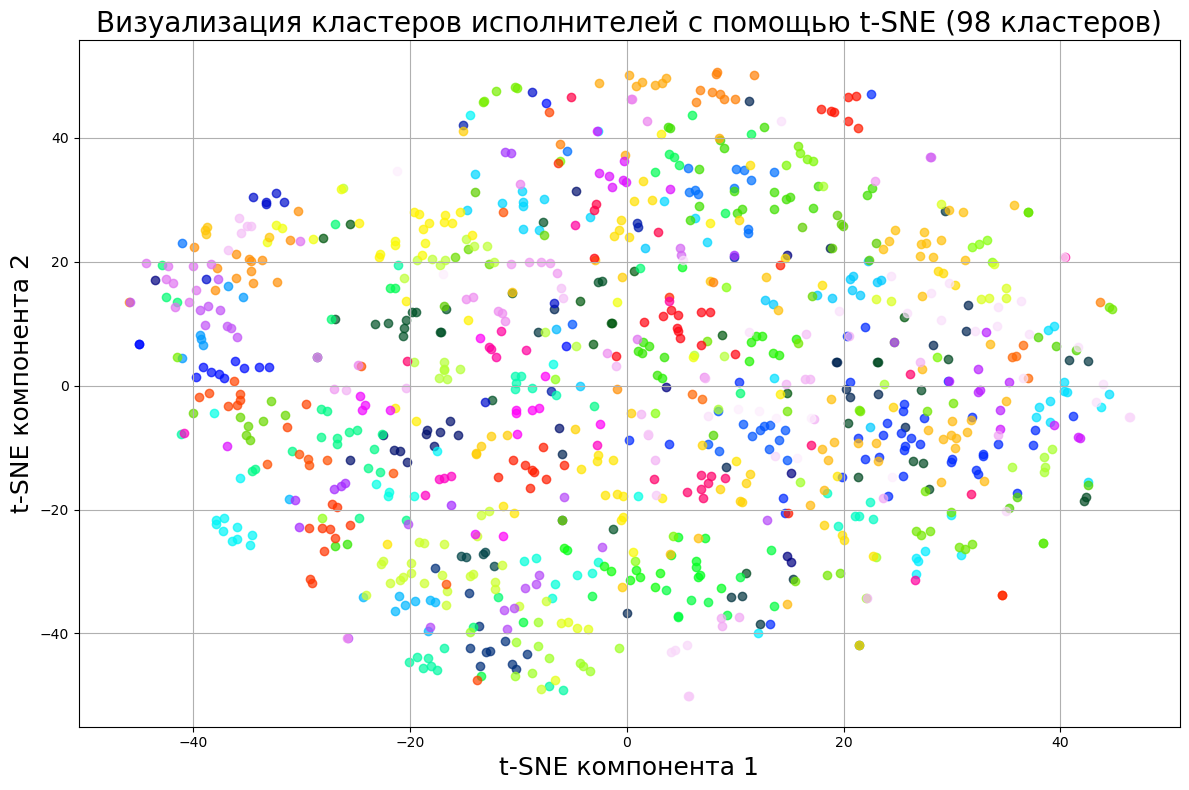

In [178]:
# -- YOUR CODE HERE --
from matplotlib.cm import get_cmap

X7 = ratings7.drop('cluster7', axis=1) 
y7 = ratings7['cluster7']

tsne7 = TSNE(n_components=2, random_state=42)
X_tsne7 = tsne7.fit_transform(X7)

n_clusters = len(np.unique(y7))
cmap = get_cmap('gist_ncar')
colors = [cmap(i/n_clusters) for i in range(n_clusters)]

plt.figure(figsize=(12, 8))

for cluster in np.unique(y7):
    mask = y7 == cluster
    plt.scatter(
        X_tsne7[mask, 0], 
        X_tsne7[mask, 1],
        c=[colors[cluster]],
        alpha=0.7,
    )
plt.title('Визуализация кластеров исполнителей с помощью t-SNE (98 кластеров)', fontsize=20)
plt.xlabel('t-SNE компонента 1', fontsize=18)
plt.ylabel('t-SNE компонента 2', fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

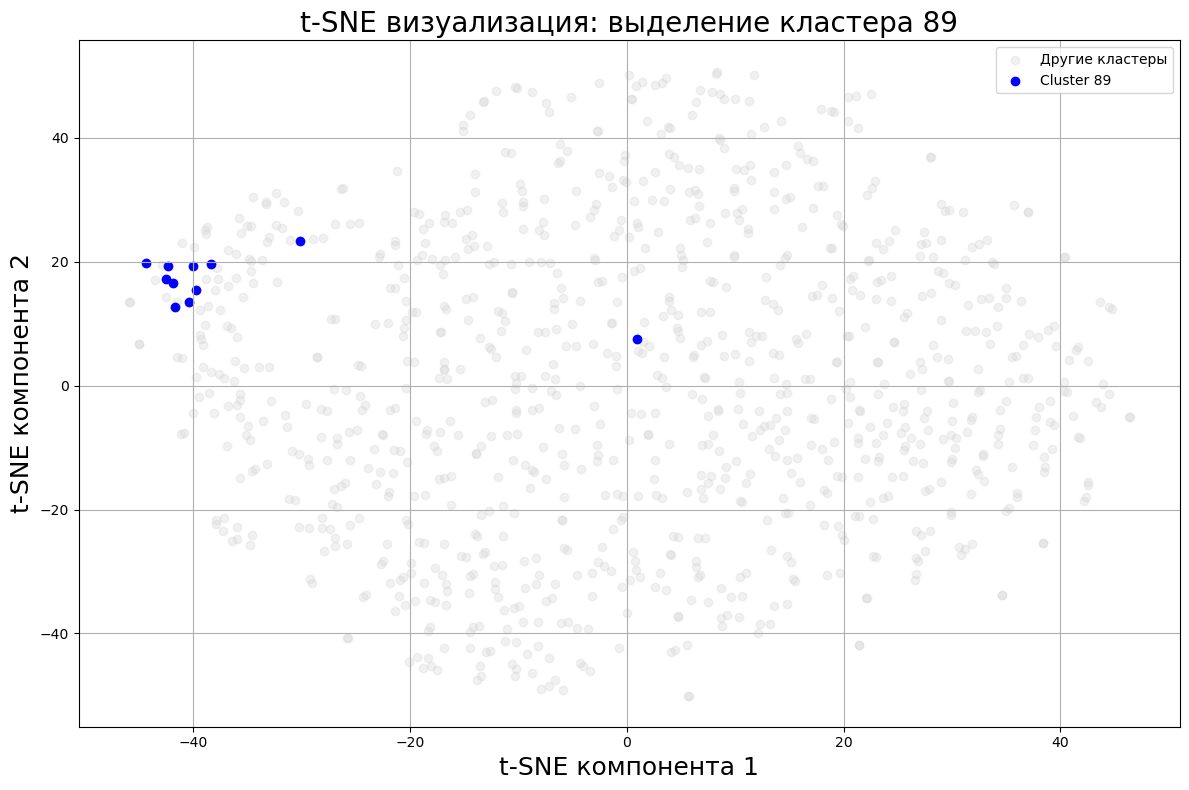

In [180]:
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne7[:, 0], X_tsne[:, 1], c='lightgray', alpha=0.3, label='Другие кластеры')
plt.scatter(X_tsne7[y7 == 89, 0], X_tsne[y7 == 89, 1], c='blue', label='Cluster 89')
plt.title('t-SNE визуализация: выделение кластера 89', fontsize = 20)
plt.xlabel('t-SNE компонента 1', fontsize=18)
plt.ylabel('t-SNE компонента 2', fontsize=18)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Ответ:** в целом да: большинство собран рядом, однако есть два выброса 